In [1]:
%matplotlib nbagg

#visualizations
import matplotlib 
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
#core imports
import numpy as np
import math

#NN
import tensorflow as tf

In [2]:
#NP
from npfunc import loglikelihood1, loglikelihood2, KLqp_gauss
from npfunc import posterior_predict, prior_predict, init_NP, g_act
#optimization
from npopt import np_iteration, sample_curves, expected_improvement, get_next_sample

In [3]:
def franke_function(x1, x2):
    return(
    .75 * np.exp(-(9 * x1 - 2) ** 2 / 4.0 - (9 * x2 - 2) ** 2 / 4.0) +
    .75 * np.exp(-(9 * x1 + 1) ** 2 / 49.0 - (9 * x2 + 1) / 10.0) +
    .5 * np.exp(-(9 * x1 - 7) ** 2 / 4.0 - (9 * x2 - 3) ** 2 / 4.0) -
    .2 * np.exp(-(9 * x1 - 4) ** 2 - (9 * x2 - 7) ** 2)
    )

In [4]:
def franke_function2(x):
    return(
    .75 * np.exp(-(9 * x[:, 0] - 2) ** 2 / 4.0 - (9 * x[:, 1] - 2) ** 2 / 4.0) +
    .75 * np.exp(-(9 * x[:, 0] + 1) ** 2 / 49.0 - (9 * x[:, 1] + 1) / 10.0) +
    .5 * np.exp(-(9 * x[:, 0] - 7) ** 2 / 4.0 - (9 * x[:, 1] - 3) ** 2 / 4.0) -
    .2 * np.exp(-(9 * x[:, 0] - 4) ** 2 - (9 * x[:, 1] - 7) ** 2)
    )

In [5]:
X = np.arange(0, 1, 0.01)
Y = np.arange(0, 1, 0.01)

In [6]:
X2, Y2 = np.meshgrid(X, Y)

In [7]:
R = franke_function(X2, Y2)

<IPython.core.display.Javascript object>


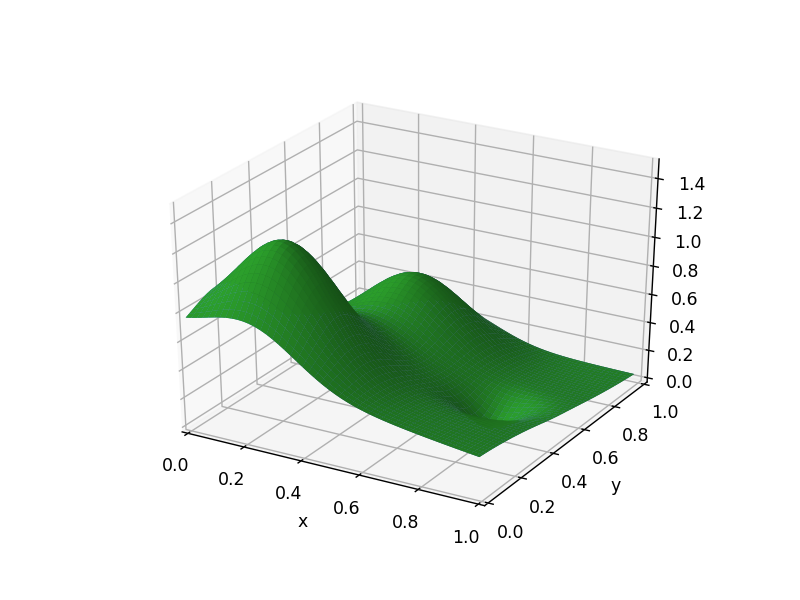

(0, 1.5)

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X2, Y2, R.T, linewidth=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0,1 )
ax.set_ylim(0,1 )
ax.set_zlim(0,1.5 )
#fig.savefig('./Figures/true3d.png')

<IPython.core.display.Javascript object>


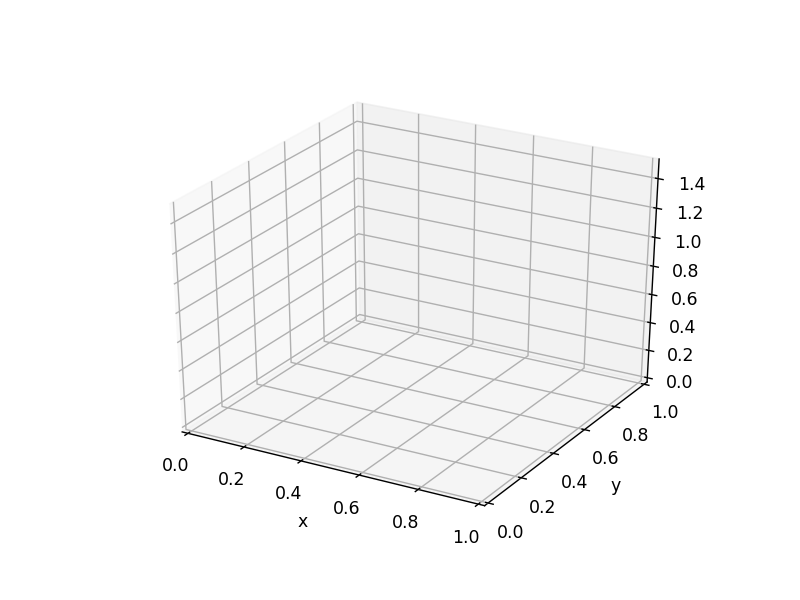

(0, 1.5)

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X2, Y2, R.T, linewidth=0, alpha=0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0,1 )
ax.set_ylim(0,1 )
ax.set_zlim(0,1.5 )

In [24]:
#network parameters
dim_r = 16
dim_z = 16
dim_h_hidden = [64, 32, 16]
dim_g_hidden = [64, 32, 16]

In [25]:
len(dim_h_hidden)

3

In [26]:
#network parameters 2
dim_r = 8
dim_z = 8
dim_h_hidden = [32, 16]
dim_g_hidden = [32, 16]

In [27]:
#create placeholders for the data
x_context = tf.placeholder(tf.float32, shape=(None, 2))
y_context = tf.placeholder(tf.float32, shape=(None, 1))
x_target = tf.placeholder(tf.float32, shape=(None, 2))
y_target = tf.placeholder(tf.float32, shape=(None, 1))

In [28]:
noise_sd = 0.05
activation_function = g_act#tf.nn.tanh
train_op_and_loss = init_NP(x_context, y_context, x_target, y_target, 
                            dim_h_hidden, dim_g_hidden, dim_r, dim_z, 
                            loglikelihood2, noise_sd = noise_sd, lr= 0.001, act_f=activation_function)

In [29]:
init = tf.global_variables_initializer()

In [30]:
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count = {'GPU': 0}))

In [31]:
sess.run(init)

### Start with a random point

In [32]:
np.random.RandomState(42)

In [16]:
#define a grid
x_test = np.array(np.meshgrid(X, X)).T.reshape(-1,2)
y_test = np.atleast_2d(franke_function2(x_test)).T

In [17]:
#x_0_0 = np.random.random(3)
#x_0_1 = np.random.random(3)
x_0_0 = np.random.randint(low=0, high=100, size=3)*0.01
x_0_1 = np.random.randint(low=0, high=100, size=3)*0.01
y_0 = franke_function(x_0_0, x_0_1) 

In [18]:
x_data = np.atleast_2d(np.array([x_0_0, x_0_1])).T.astype(np.float32)

In [19]:
y_data = np.atleast_2d(franke_function2(x_data)).T

In [20]:
x_data

array([[0.76, 0.95],
       [0.63, 0.94],
       [0.9 , 0.54]], dtype=float32)

In [ ]:
y_pred_history = np.zeros(shape = (0, 100, 100))

In [42]:
for i in range(5000):
    #perform 1 np iteration 
    a = np_iteration(x_data, y_data, x_context, y_context, 
                     x_target, y_target, sess, train_op_and_loss)
    if(i % 500 == 0):
        #print(i, a[1]/x_data.shape[0])
        print(i, a[1])

0 -2.0733824
500 -2.0736527
1000 -2.0730405
1500 -2.07594
2000 -2.075898
2500 -2.076236
3000 -2.0752017
3500 -2.0750937
4000 -2.0749426
4500 -2.0729363


In [ ]:
n_draws = 100
predict_op = posterior_predict(x_data, y_data , x_test, dim_h_hidden, dim_g_hidden, dim_r, dim_z, epsilon=None, n_draws = n_draws)
y_pred = sess.run(predict_op)
y_pred2 = np.reshape(y_pred[0], (100, 100, n_draws))


#find best prediction 
fval = y_pred2[np.floor(x_data[:,0] * 100).astype(int), np.floor(x_data[:,1] * 100).astype(int), :]
errsample = np.zeros(shape=(n_draws))
for i in range(n_draws):
    errsample[i] = np.mean(np.square(fval[:, i] -  y_data[:,0]))
bestsurf = np.argmin(errsample)

In [43]:
n_draws = 100
y_star_mat, y_star_mean, y_star_sigma = sample_curves(x_data, y_data, x_test, 
                                            dim_h_hidden, dim_g_hidden, dim_r, dim_z,
                                            sess, epsilon_std=5.0, n_draws=n_draws, act_f=activation_function)

In [44]:
y_star_mean2 = np.reshape(y_star_mean, (100, 100))
y_star_sigma2 = np.reshape(y_star_sigma, (100, 100))

<IPython.core.display.Javascript object>


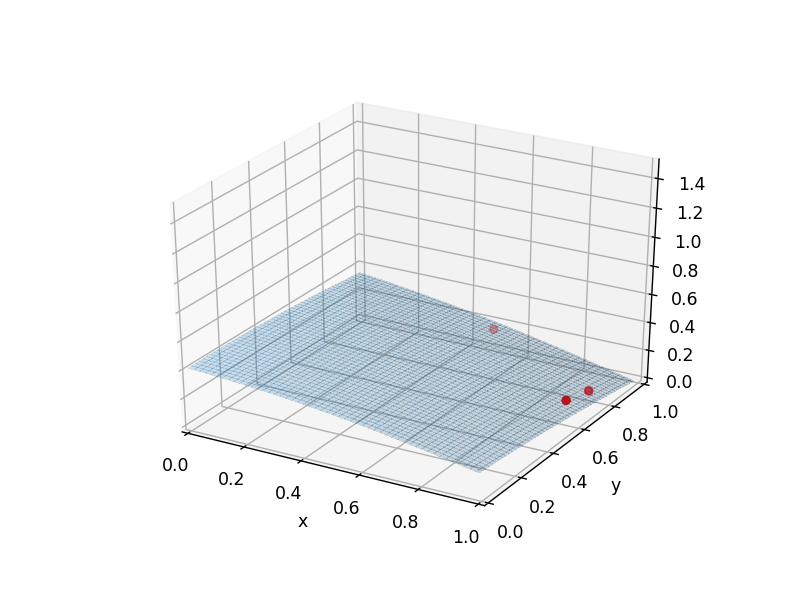

(0, 1.5)

In [49]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#surf = ax.plot_surface(X2, Y2, y_pred2[:,:,bestsurf], linewidth=0, antialiased=False, alpha=0.2)
surf = ax.plot_surface(X2, Y2, y_star_mean2, linewidth=0, antialiased=False, alpha=0.2)
ax.scatter3D(x_data[:, 1], x_data[:,0], y_data, c='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0,1 )
ax.set_ylim(0,1 )
ax.set_zlim(0,1.5 )

In [ ]:
y_pred1 = np.reshape(y_star_mat[0], (100, 100, n_draws))

In [ ]:
y_pred1.shape

In [ ]:
np.amax( np.sum(y_pred1, axis=2)) - np.amin( np.sum(y_pred1, axis=2))

<IPython.core.display.Javascript object>


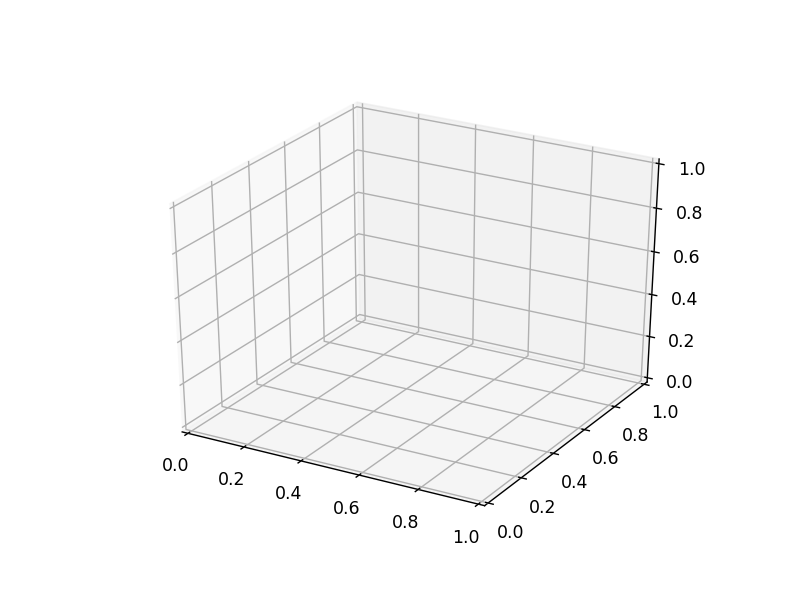

NameError: name 'y_pred1' is not defined

In [53]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#surf = ax.plot_surface(X2, Y2, y_pred1[:,:,bestsurf], linewidth=0, antialiased=False, alpha=0.2)
surf = ax.plot_surface(X2, Y2, np.mean(y_pred1, axis=2), linewidth=0, antialiased=False, alpha=0.2)
#ax.scatter3D(x_data[:, 1], x_data[:,0], y_data, c='r')

In [51]:
x_suggested = np.zeros(shape=(0, 2))
y_suggested = np.zeros(shape=(0))
y_max_loc = np.zeros(shape=(0, 2))
y_max_val = np.zeros(shape=(0))
y_pred_history = np.zeros(shape = (0, 100, 100))

In [52]:
#find new data point 
#x_new_0, x_new_1 = np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)
#x_data_new = np.atleast_2d(np.array([x_new_0 * 0.01, x_new_1*0.01])).astype(np.float32)

x_new_0, x_new_1 = np.unravel_index(np.argmax(y_star_mean2), y_star_mean2.shape)
x_data_new = np.atleast_2d(np.array([x_new_0 * 0.01, x_new_1*0.01])).astype(np.float32)
print(x_data_new)
#record the new point
x_suggested = np.append(x_suggested, x_data_new, axis=0)
y_suggested = np.append(y_suggested, np.amax(y_star_mean2))

y_max_loc = np.append(y_max_loc, np.atleast_2d(np.array(np.unravel_index(np.argmax(y_star_mean2), y_star_mean2.shape))), axis=0)
y_max_val = np.append( y_max_val, np.amax(y_star_mean2))

y_pred_history = np.append(y_pred_history, np.reshape(y_star_mean2, (1, 100, 100)), axis = 0)

[[0.11 0.  ]]


In [ ]:
x_data

In [54]:
n_points = 5
#x_suggested = np.zeros(shape=(0, 2))
#y_suggested = np.zeros(shape=(0))
#y_pred_history = np.zeros(shape = (0, 100, 100))

for i2 in range(n_points): 
#     #get new maximum point
#     x_new_0, x_new_1 = np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)
#     x_data_new = np.atleast_2d(np.array([x_new_0 * 0.01, x_new_1*0.01])).astype(np.float32)
#     print(x_data_new)
#     #record the new point
#     x_suggested = np.append(x_suggested, x_data_new, axis=0)
#     y_suggested = np.append(y_suggested, np.amax(y_pred2[:, :, bestsurf]))
#     y_pred_history = np.append(y_pred_history, np.reshape(y_pred2[:, :, bestsurf], (1, 100, 100)), axis = 0)
    
    #if data point is in the data already, choose a random one 
    if np.any(np.isclose(x_data_new, x_data).mean(axis=1) == 1):
        x_new_0 = np.random.randint(low=0, high=100) * 0.01
        x_new_1 = np.random.randint(low=0, high=100) * 0.01
        #x_new_0 = np.random.random(1)
        #x_new_1 = np.random.random(1)
        
        x_data_new = np.atleast_2d(np.array([x_new_0, x_new_1])).astype(np.float32)
        print("Choosing random point")
        print(x_data_new)
    #add new point
    x_data = np.append(x_data, x_data_new, axis=0)
    y_data = np.atleast_2d(franke_function2(x_data)).T
    
    #train with new data
    for i in range(5000):
        #x_c = np.atleast_2d(np.array([x_0_0, x_0_1])).T.astype(np.float32)
        #y_c = np.atleast_2d(franke_function2(x_c)).T
#         N = np.random.randint(2, x_data.shape[0]) + 1
#         x_c_id = np.random.randint(0, x_data.shape[0], size=N)
#         x_c = x_data[x_c_id, :]
#         y_c = y_data[x_c_id, :]
#         a = sess.run(train_op_and_loss, feed_dict={x_context: x_c, y_context: y_c, x_target:x_data, y_target:y_data})

#         N = np.random.randint(2, x_data.shape[0]) + 1
#         x_c_id = np.random.randint(0, x_data.shape[0], size=N)
#         x_c = x_data[x_c_id, :]
#         y_c = y_data[x_c_id, :]
#         #x_t = np.delete(x_data, x_c_id , 0)
#         #y_t = np.delete(y_data, x_c_id , 0)
#         a = sess.run(train_op_and_loss, feed_dict={x_context: x_c, y_context: y_c, x_target:x_data, y_target:y_data})

        a = np_iteration(x_data, y_data, x_context, y_context, 
                     x_target, y_target, sess, train_op_and_loss)
        
        #print loss 
        if(i % 1000 == 0):
            #print(i, a[1]/x_data.shape[0])
            print(i, a[1])
    
    #predict n_draws surfaces 
    
    n_draws = 100
    
    y_star_mat, y_star_mean, y_star_sigma = sample_curves(x_data, y_data, x_test, 
                                            dim_h_hidden, dim_g_hidden, dim_r, dim_z,
                                            sess, epsilon_std=5.0, n_draws=n_draws, act_f=activation_function)
    
    
    
    
    #predict_op = posterior_predict(x_data, y_data , x_test, dim_h_hidden, dim_g_hidden, dim_r, dim_z, epsilon=None, n_draws = n_draws)
    #y_pred = sess.run(predict_op)
    #y_pred1 = np.reshape(y_pred[1], (100, 100, n_draws))
    #y_pred2 = np.reshape(y_pred[0], (100, 100, n_draws))
    y_pred2 = np.reshape(y_star_mean, (100, 100))
    stdsurf = np.reshape(y_star_sigma, (100, 100))
    
    #find best predicted surface
    #fval = y_pred2[np.floor(x_data[:,0] * 100).astype(int), np.floor(x_data[:,1] * 100).astype(int), :]
#     errsample = np.zeros(shape=(n_draws))
#     for i in range(n_draws):
#         errsample[i] = np.mean(np.square(fval[:, i] -  y_data[:,0]))
#     bestsurf = np.argmin(errsample)
#     stdsurf = np.std(y_pred2, axis=2)

    
    
    #get new maximum point
    #x_new_0, x_new_1 = np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)
    #x_data_new = np.atleast_2d(np.array([x_new_0 * 0.01, x_new_1*0.01])).astype(np.float32)
    #if point is already evaluated, get one with maximum uncertainty 
    #if np.any(np.isclose(x_data_new, x_data).mean(axis=1) == 1):
#     x_new_0, x_new_1 = np.unravel_index(np.argmax(stdsurf), stdsurf.shape)
#     x_data_new = np.atleast_2d(np.array([x_new_0 * 0.01, x_new_1*0.01])).astype(np.float32)
#     if np.any(np.isclose(x_data_new, x_data).mean(axis=1) == 1):
#         x_new_0, x_new_1 = np.unravel_index(np.argmax(y_pred2), y_pred2.shape)
#         x_data_new = np.atleast_2d(np.array([x_new_0 * 0.01, x_new_1*0.01])).astype(np.float32)
    
#     print(x_data_new)
    ei = expected_improvement(y_star_mean, y_star_sigma, y_data, y_data)
    x_data_new, y_data_new = get_next_sample(x_test, np.argmax(ei), y_t=y_test)


    #record the new point
    x_suggested = np.append(x_suggested, x_data_new, axis=0)
    y_suggested = np.append(y_suggested, np.amax(y_pred2))
    y_pred_history = np.append(y_pred_history, np.reshape(y_pred2, (1, 100, 100)), axis = 0)
    
    #record the predicted maximum value 
    #y_suggested[i2] = np.amax(y_pred2[:, :, bestsurf])
    #np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)
    #y_max_loc[i, :] = np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)
    #y_max_val[i] = y_pred2[y_max_loc[i, 0],  y_max_loc[i, 1], bestsurf]
    y_max_loc = np.append(y_max_loc, np.atleast_2d(np.array(np.unravel_index(np.argmax(y_pred2), y_pred2.shape))), axis=0)
    y_max_val = np.append( y_max_val, np.amax(y_pred2))
    
    print("Next suggested point: ", x_suggested[-1, :])
    print("Current maximum: ", y_max_val[-1], ", at: ", y_max_loc[-1] )
    
    

0 4.1204896
1000 -2.0762725
2000 -2.0763562
3000 -2.0767071
4000 -2.076405
Next suggested point:  [0. 0.]
Current maximum:  0.8570406436920166 , at:  [0. 0.]
0 -1.7179303
1000 -2.0763133
2000 -2.0764654
3000 -2.0765343
4000 -2.0763245
Next suggested point:  [0.4 0. ]
Current maximum:  0.9279196858406067 , at:  [40.  0.]
0 1.7709134
1000 -2.0757365
2000 -2.075847
3000 -2.0766728
4000 -2.0762303
Next suggested point:  [0.13 0.  ]
Current maximum:  0.8424274921417236 , at:  [13.  0.]
0 -2.0754142
1000 -2.075877
2000 -2.075579
3000 -2.0756536
4000 -2.076422
Next suggested point:  [0.16 0.  ]
Current maximum:  0.8494222164154053 , at:  [16.  0.]
0 -2.075623
1000 -2.0767217
2000 -2.0765364
3000 -2.0767276
4000 -2.0767682
Next suggested point:  [0.17 0.  ]
Current maximum:  0.8564052581787109 , at:  [17.  0.]


In [ ]:
y_star_mean2.shape

In [55]:
ei = expected_improvement(y_star_mean, y_star_sigma, y_data, y_data)

In [ ]:
get_next_sample(x_test, np.argmax(ei), y_t=y_test)

In [ ]:
x_test.shape

In [ ]:
np.amin(ei)

In [ ]:
x_data.shape

In [ ]:
y_max_loc

In [ ]:
x_data

In [ ]:
newx, newy = np.unravel_index(np.argmax(y_pred2), y_pred2.shape)
print(newx, newy)
print(y_pred2[newx, newy])

In [ ]:
franke_function(newx*0.01, newy*0.01)

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d', )
surf = ax.plot_surface(X2, Y2, y_pred2, linewidth=0, antialiased=False, alpha=0.3)
ax.scatter3D(x_data[:, 1], x_data[:,0], y_data, c='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('value')
ax.scatter3D(newy*0.01, newx*0.01, y_pred2[newx, newy], c='m')


<IPython.core.display.Javascript object>


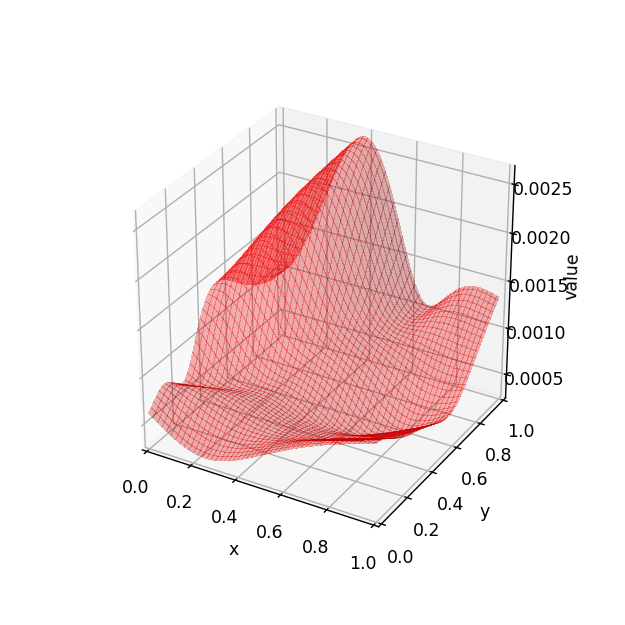

(0, 1)

In [60]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d', )
surf = ax.plot_surface(X2, Y2, stdsurf, linewidth=0, antialiased=False, alpha=0.3, color='r')
#ax.scatter3D(x_data[:, 1], x_data[:,0], y_data, c='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('value')
ax.set_xlim(0,1 )
ax.set_ylim(0,1 )
#ax.set_zlim(0,1.5 )
#ax.scatter3D(newy*0.01, newx*0.01, y_pred2[newx, newy, bestsurf], c='m')

In [ ]:
np.unravel_index(np.argmax(np.std(y_pred2, axis=2)), np.std(y_pred2, axis=2).shape)

In [ ]:
np.std(y_pred2, axis=2).shape

In [ ]:
np.amax(y_pred1[:,:, bestsurf])

In [ ]:
np.amin(y_pred1[:,:, bestsurf])

In [ ]:
len(d)

In [ ]:
np.amax(np.std(y_pred2, axis=2))

In [ ]:
np.amin(np.std(y_pred2, axis=2))

In [ ]:
x_data

In [ ]:
y_data

In [ ]:
y_star_mat[0].shape

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(y_pred2[:,:,bestsurf], cmap='hot', interpolation='nearest')
ax1.scatter(x_data[:, 1]*100, x_data[:,0]*100, c='b')
ax1.scatter(np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)[1], np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)[0], c='m')
ax1.scatter(21,21, c='r')
ax2 = fig.add_subplot(122)
ax2.imshow(R.T, cmap='hot', interpolation='nearest')
ax2.scatter(x_data[:, 1]*100, x_data[:,0]*100, c='b')
ax2.set_xlabel('x')

In [ ]:
y_pred_history.shape

In [ ]:
fig1 = plt.figure(101, figsize=(5,5))
for i in range(y_pred_history.shape[0]):
    ax = fig1.gca(projection='3d', )
    surf = ax.plot_surface(X2, Y2, y_pred_history[i], linewidth=0, antialiased=False, alpha=0.2)
    ax.scatter3D(x_data[0:i+3, 1], x_data[0:i+3,0], y_data[0:i+3], c='r')
    ax.scatter3D(x_suggested[i, 1], x_suggested[i, 0], y_suggested[i], c='k', s=200, marker = 'x')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('value')
    ax.set_xlim(0,1 )
    ax.set_ylim(0,1 )
    ax.set_zlim(0,1.5 )
    fig1.savefig("./Figures/Franke1/" + 'test_' + str(i) + '.png')
    ax.clear()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(y_pred_history[i], cmap='hot', interpolation='nearest')
ax1.scatter(x_data[:, 1]*100, x_data[:,0]*100, c='b')
ax1.scatter(np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)[1], np.unravel_index(np.argmax(y_pred2[:,:,bestsurf]), y_pred2[:,:,bestsurf].shape)[0], c='m')
ax1.scatter(21,21, c='r')
ax2 = fig.add_subplot(122)
ax2.imshow(R.T, cmap='hot', interpolation='nearest')
ax2.scatter(x_data[:, 1]*100, x_data[:,0]*100, c='b')
ax2.set_xlabel('x')

In [ ]:
fig2 = plt.figure(201, figsize=(7,5))
#ax = fig2.add_subplot(111)
ax1 = fig2.add_axes([0.1,0.1,0.8,0.8])
ax2 = fig2.add_axes([0.85,0.1,0.05,0.8])
for i in range(y_pred_history.shape[0]):
    #ax1.clear()
    #ax2.clear()
    #ax.clear()
    fig2.clear()
    ax1 = fig2.add_axes([0.1,0.1,0.8,0.8])
    ax2 = fig2.add_axes([0.82,0.1,0.05,0.8])
    ax1.axis('square')
    h = ax1.imshow(y_pred_history[i], cmap='hot')
    #ax1.scatter(x_data[0:i+3, 1]*100, x_data[0:i+3,0]*100, c='b')
    ax1.scatter(x_data[0:i+3, 1]*100, x_data[0:i+3,0]*100, c='b')
    ax1.scatter(x_suggested[i, 1]*100, x_suggested[i, 0]*100, c='m', marker='x', s=200)
    ax1.set_xticks([0, 20, 40, 60, 80, 100])
    ax1.set_yticks([0, 20, 40, 60, 80, 100])
    ax1.set_xticklabels(ax1.get_xticks()/100)
    ax1.set_yticklabels(ax1.get_yticks()/100)
    fig2.colorbar(h, cax=ax2) #, shrink = 0.8)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    fig2.savefig("./Figures/Franke2/" + 'test_' + str(i) + '.png')

In [ ]:
ax.get_xticks()/100

In [ ]:
fig2 = plt.figure(201)
#fig2.clear()
#ax = fig2.add_subplot(111)
ax1 = fig2.add_axes([0.1,0.1,0.8,0.8])
ax2 = fig2.add_axes([0.85,0.1,0.05,0.8])
i = 0
#ax.clear()
ax1.axis('square')
h = ax1.imshow(y_pred_history[1], cmap='hot')
ax1.scatter(x_data[0:i+3, 1]*100, x_data[0:i+3,0]*100, c='b')
ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax1.set_xticklabels(ax1.get_xticks()/100)
ax1.set_yticklabels(ax1.get_yticks()/100)
fig2.colorbar(h, cax=ax2) #, shrink = 0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
#fig2.savefig("./Figures/Franke2/" + 'test_' + str(i) + '.png')

In [ ]:
fig3.clear()

In [ ]:
fig3 = plt.figure(301)
ax1 = fig3.add_axes([0.1,0.1,0.8,0.8])
ax2 = fig3.add_axes([0.85,0.1,0.05,0.8])
ax1.axis('square')
ax1.set_xticks([0, 20, 40, 60, 80, 100])
ax1.set_yticks([0, 20, 40, 60, 80, 100])
ax1.set_xticklabels(ax1.get_xticks()/100)
ax1.set_yticklabels(ax1.get_yticks()/100)
h = ax1.imshow(R.T, cmap='hot')
fig3.colorbar(h, cax=ax2)
fig3.savefig("./Figures/Franke2/" + 'true.png')

In [ ]:
x_data

In [ ]:
np.isclose(x_suggested, [0.21,0.21])